In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'basal_seg',
    'balance_data'  : True,
    'exclude'       : [],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_0_0_0_1_e_e_n_e_0_0_e_0_0_basal_seg_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1079604, 828)
(1079604, 3)
validation
(190293, 828)
(190293, 3)
test
(137379, 828)
(137379, 3)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 3)                 387       


Total params: 1538307 (5.87 MB)


Trainable params: 1538307 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/108 [..............................] - ETA: 2:10 - loss: 1.2073 - STD: 0.1597 - MAE: 0.4457

  5/108 [>.............................] - ETA: 1s - loss: 1.1454 - STD: 0.0956 - MAE: 0.4436  

  9/108 [=>............................] - ETA: 1s - loss: 1.1230 - STD: 0.0786 - MAE: 0.4421

 13/108 [==>...........................] - ETA: 1s - loss: 1.0999 - STD: 0.0674 - MAE: 0.4387

 17/108 [===>..........................] - ETA: 1s - loss: 1.0675 - STD: 0.0725 - MAE: 0.4310

 21/108 [====>.........................] - ETA: 1s - loss: 1.0209 - STD: 0.0885 - MAE: 0.4178

 25/108 [=====>........................] - ETA: 1s - loss: 0.9726 - STD: 0.1118 - MAE: 0.4012

 29/108 [=======>......................] - ETA: 1s - loss: 0.9327 - STD: 0.1346 - MAE: 0.3855

 30/108 [=======>......................] - ETA: 2s - loss: 0.9245 - STD: 0.1399 - MAE: 0.3820

 34/108 [========>.....................] - ETA: 2s - loss: 0.8922 - STD: 0.1583 - MAE: 0.3686

 38/108 [=========>....................] - ETA: 2s - loss: 0.8644 - STD: 0.1728 - MAE: 0.3576

 42/108 [==========>...................] - ETA: 2s - loss: 0.8403 - STD: 0.1840 - MAE: 0.3486

 46/108 [===========>..................] - ETA: 1s - loss: 0.8184 - STD: 0.1936 - MAE: 0.3404

 50/108 [============>.................] - ETA: 1s - loss: 0.7978 - STD: 0.2030 - MAE: 0.3321

 54/108 [==============>...............] - ETA: 1s - loss: 0.7779 - STD: 0.2122 - MAE: 0.3239

 58/108 [===============>..............] - ETA: 1s - loss: 0.7585 - STD: 0.2209 - MAE: 0.3157

 62/108 [================>.............] - ETA: 1s - loss: 0.7395 - STD: 0.2289 - MAE: 0.3078

 66/108 [=================>............] - ETA: 1s - loss: 0.7201 - STD: 0.2365 - MAE: 0.2997

 70/108 [==================>...........] - ETA: 0s - loss: 0.6999 - STD: 0.2441 - MAE: 0.2912

 74/108 [===================>..........] - ETA: 0s - loss: 0.6800 - STD: 0.2519 - MAE: 0.2826

 78/108 [====================>.........] - ETA: 0s - loss: 0.6608 - STD: 0.2595 - MAE: 0.2741

 82/108 [=====================>........] - ETA: 0s - loss: 0.6427 - STD: 0.2667 - MAE: 0.2660

 86/108 [======================>.......] - ETA: 0s - loss: 0.6261 - STD: 0.2734 - MAE: 0.2585

 90/108 [========================>.....] - ETA: 0s - loss: 0.6104 - STD: 0.2796 - MAE: 0.2516

 94/108 [=========================>....] - ETA: 0s - loss: 0.5959 - STD: 0.2854 - MAE: 0.2450

 98/108 [==========================>...] - ETA: 0s - loss: 0.5826 - STD: 0.2908 - MAE: 0.2390

102/108 [===========================>..] - ETA: 0s - loss: 0.5699 - STD: 0.2958 - MAE: 0.2334

106/108 [============================>.] - ETA: 0s - loss: 0.5578 - STD: 0.3004 - MAE: 0.2281

108/108 [==============================] - 4s 29ms/step - loss: 0.5522 - STD: 0.3025 - MAE: 0.2256 - val_loss: 0.2455 - val_STD: 0.4129 - val_MAE: 0.0984


Epoch 2/10000


  1/108 [..............................] - ETA: 4s - loss: 0.2587 - STD: 0.4163 - MAE: 0.0962

  5/108 [>.............................] - ETA: 1s - loss: 0.2513 - STD: 0.4162 - MAE: 0.0947

  9/108 [=>............................] - ETA: 1s - loss: 0.2486 - STD: 0.4170 - MAE: 0.0935

 13/108 [==>...........................] - ETA: 1s - loss: 0.2481 - STD: 0.4180 - MAE: 0.0927

 17/108 [===>..........................] - ETA: 1s - loss: 0.2453 - STD: 0.4187 - MAE: 0.0916

 21/108 [====>.........................] - ETA: 1s - loss: 0.2430 - STD: 0.4192 - MAE: 0.0908

 25/108 [=====>........................] - ETA: 1s - loss: 0.2424 - STD: 0.4195 - MAE: 0.0903

 29/108 [=======>......................] - ETA: 1s - loss: 0.2418 - STD: 0.4199 - MAE: 0.0899

 33/108 [========>.....................] - ETA: 1s - loss: 0.2393 - STD: 0.4203 - MAE: 0.0891

 37/108 [=========>....................] - ETA: 1s - loss: 0.2376 - STD: 0.4206 - MAE: 0.0885

 41/108 [==========>...................] - ETA: 1s - loss: 0.2364 - STD: 0.4210 - MAE: 0.0880

 45/108 [===========>..................] - ETA: 0s - loss: 0.2348 - STD: 0.4214 - MAE: 0.0873

 49/108 [============>.................] - ETA: 0s - loss: 0.2334 - STD: 0.4218 - MAE: 0.0867

 53/108 [=============>................] - ETA: 0s - loss: 0.2324 - STD: 0.4222 - MAE: 0.0863

 57/108 [==============>...............] - ETA: 0s - loss: 0.2308 - STD: 0.4224 - MAE: 0.0858

 61/108 [===============>..............] - ETA: 0s - loss: 0.2295 - STD: 0.4227 - MAE: 0.0853

 65/108 [=================>............] - ETA: 0s - loss: 0.2281 - STD: 0.4230 - MAE: 0.0847

 69/108 [==================>...........] - ETA: 0s - loss: 0.2272 - STD: 0.4233 - MAE: 0.0843

 73/108 [===================>..........] - ETA: 0s - loss: 0.2267 - STD: 0.4236 - MAE: 0.0841

 77/108 [====================>.........] - ETA: 0s - loss: 0.2262 - STD: 0.4239 - MAE: 0.0837

 81/108 [=====================>........] - ETA: 0s - loss: 0.2254 - STD: 0.4241 - MAE: 0.0833

 85/108 [======================>.......] - ETA: 0s - loss: 0.2245 - STD: 0.4244 - MAE: 0.0830

 89/108 [=======================>......] - ETA: 0s - loss: 0.2241 - STD: 0.4245 - MAE: 0.0828

 93/108 [========================>.....] - ETA: 0s - loss: 0.2233 - STD: 0.4247 - MAE: 0.0825

 97/108 [=========================>....] - ETA: 0s - loss: 0.2225 - STD: 0.4249 - MAE: 0.0821

101/108 [===========================>..] - ETA: 0s - loss: 0.2217 - STD: 0.4251 - MAE: 0.0819

105/108 [============================>.] - ETA: 0s - loss: 0.2208 - STD: 0.4253 - MAE: 0.0815

108/108 [==============================] - 2s 18ms/step - loss: 0.2202 - STD: 0.4254 - MAE: 0.0813 - val_loss: 0.2238 - val_STD: 0.4292 - val_MAE: 0.0782


Epoch 3/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1938 - STD: 0.4305 - MAE: 0.0716

  4/108 [>.............................] - ETA: 1s - loss: 0.1952 - STD: 0.4303 - MAE: 0.0722

  8/108 [=>............................] - ETA: 1s - loss: 0.1976 - STD: 0.4305 - MAE: 0.0725

 12/108 [==>...........................] - ETA: 1s - loss: 0.1959 - STD: 0.4305 - MAE: 0.0723

 16/108 [===>..........................] - ETA: 1s - loss: 0.1960 - STD: 0.4309 - MAE: 0.0720

 20/108 [====>.........................] - ETA: 1s - loss: 0.1961 - STD: 0.4312 - MAE: 0.0718

 24/108 [=====>........................] - ETA: 1s - loss: 0.1953 - STD: 0.4313 - MAE: 0.0716

 28/108 [======>.......................] - ETA: 1s - loss: 0.1944 - STD: 0.4314 - MAE: 0.0713

 32/108 [=======>......................] - ETA: 1s - loss: 0.1938 - STD: 0.4316 - MAE: 0.0710

 36/108 [=========>....................] - ETA: 1s - loss: 0.1931 - STD: 0.4319 - MAE: 0.0707

 40/108 [==========>...................] - ETA: 1s - loss: 0.1933 - STD: 0.4320 - MAE: 0.0707

 44/108 [===========>..................] - ETA: 0s - loss: 0.1932 - STD: 0.4320 - MAE: 0.0706

 48/108 [============>.................] - ETA: 0s - loss: 0.1930 - STD: 0.4320 - MAE: 0.0705

 52/108 [=============>................] - ETA: 0s - loss: 0.1926 - STD: 0.4321 - MAE: 0.0704

 56/108 [==============>...............] - ETA: 0s - loss: 0.1922 - STD: 0.4322 - MAE: 0.0703

 60/108 [===============>..............] - ETA: 0s - loss: 0.1919 - STD: 0.4322 - MAE: 0.0702

 64/108 [================>.............] - ETA: 0s - loss: 0.1916 - STD: 0.4323 - MAE: 0.0701

 68/108 [=================>............] - ETA: 0s - loss: 0.1915 - STD: 0.4324 - MAE: 0.0700

 72/108 [===================>..........] - ETA: 0s - loss: 0.1919 - STD: 0.4324 - MAE: 0.0700

 76/108 [====================>.........] - ETA: 0s - loss: 0.1917 - STD: 0.4326 - MAE: 0.0699

 80/108 [=====================>........] - ETA: 0s - loss: 0.1914 - STD: 0.4326 - MAE: 0.0697

 84/108 [======================>.......] - ETA: 0s - loss: 0.1911 - STD: 0.4327 - MAE: 0.0696

 88/108 [=======================>......] - ETA: 0s - loss: 0.1909 - STD: 0.4327 - MAE: 0.0695

 92/108 [========================>.....] - ETA: 0s - loss: 0.1907 - STD: 0.4328 - MAE: 0.0695

 96/108 [=========================>....] - ETA: 0s - loss: 0.1904 - STD: 0.4328 - MAE: 0.0694

100/108 [==========================>...] - ETA: 0s - loss: 0.1904 - STD: 0.4329 - MAE: 0.0693

104/108 [===========================>..] - ETA: 0s - loss: 0.1909 - STD: 0.4329 - MAE: 0.0694

108/108 [==============================] - ETA: 0s - loss: 0.1913 - STD: 0.4329 - MAE: 0.0695

108/108 [==============================] - 2s 18ms/step - loss: 0.1913 - STD: 0.4329 - MAE: 0.0695 - val_loss: 0.2094 - val_STD: 0.4373 - val_MAE: 0.0678


Epoch 4/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1946 - STD: 0.4359 - MAE: 0.0682

  5/108 [>.............................] - ETA: 1s - loss: 0.1987 - STD: 0.4340 - MAE: 0.0702

  9/108 [=>............................] - ETA: 1s - loss: 0.1929 - STD: 0.4340 - MAE: 0.0690

 13/108 [==>...........................] - ETA: 1s - loss: 0.1914 - STD: 0.4337 - MAE: 0.0690

 17/108 [===>..........................] - ETA: 1s - loss: 0.1890 - STD: 0.4334 - MAE: 0.0687

 21/108 [====>.........................] - ETA: 1s - loss: 0.1883 - STD: 0.4333 - MAE: 0.0686

 25/108 [=====>........................] - ETA: 1s - loss: 0.1868 - STD: 0.4334 - MAE: 0.0683

 29/108 [=======>......................] - ETA: 1s - loss: 0.1863 - STD: 0.4337 - MAE: 0.0679

 33/108 [========>.....................] - ETA: 1s - loss: 0.1862 - STD: 0.4339 - MAE: 0.0677

 37/108 [=========>....................] - ETA: 1s - loss: 0.1860 - STD: 0.4341 - MAE: 0.0675

 41/108 [==========>...................] - ETA: 1s - loss: 0.1864 - STD: 0.4341 - MAE: 0.0676

 45/108 [===========>..................] - ETA: 0s - loss: 0.1859 - STD: 0.4341 - MAE: 0.0675

 49/108 [============>.................] - ETA: 0s - loss: 0.1854 - STD: 0.4342 - MAE: 0.0674

 53/108 [=============>................] - ETA: 0s - loss: 0.1851 - STD: 0.4343 - MAE: 0.0672

 57/108 [==============>...............] - ETA: 0s - loss: 0.1848 - STD: 0.4344 - MAE: 0.0671

 61/108 [===============>..............] - ETA: 0s - loss: 0.1843 - STD: 0.4345 - MAE: 0.0669

 65/108 [=================>............] - ETA: 0s - loss: 0.1835 - STD: 0.4346 - MAE: 0.0667

 69/108 [==================>...........] - ETA: 0s - loss: 0.1829 - STD: 0.4346 - MAE: 0.0665

 73/108 [===================>..........] - ETA: 0s - loss: 0.1822 - STD: 0.4347 - MAE: 0.0663

 77/108 [====================>.........] - ETA: 0s - loss: 0.1816 - STD: 0.4348 - MAE: 0.0661

 81/108 [=====================>........] - ETA: 0s - loss: 0.1812 - STD: 0.4349 - MAE: 0.0660

 85/108 [======================>.......] - ETA: 0s - loss: 0.1809 - STD: 0.4350 - MAE: 0.0659

 89/108 [=======================>......] - ETA: 0s - loss: 0.1807 - STD: 0.4350 - MAE: 0.0658

 93/108 [========================>.....] - ETA: 0s - loss: 0.1807 - STD: 0.4351 - MAE: 0.0657

 97/108 [=========================>....] - ETA: 0s - loss: 0.1806 - STD: 0.4351 - MAE: 0.0657

101/108 [===========================>..] - ETA: 0s - loss: 0.1804 - STD: 0.4352 - MAE: 0.0656

105/108 [============================>.] - ETA: 0s - loss: 0.1801 - STD: 0.4352 - MAE: 0.0655

108/108 [==============================] - 2s 18ms/step - loss: 0.1799 - STD: 0.4352 - MAE: 0.0654 - val_loss: 0.2009 - val_STD: 0.4348 - val_MAE: 0.0688


Epoch 5/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1671 - STD: 0.4366 - MAE: 0.0619

  4/108 [>.............................] - ETA: 1s - loss: 0.1730 - STD: 0.4366 - MAE: 0.0631

  8/108 [=>............................] - ETA: 1s - loss: 0.1729 - STD: 0.4364 - MAE: 0.0632

 12/108 [==>...........................] - ETA: 1s - loss: 0.1749 - STD: 0.4365 - MAE: 0.0635

 16/108 [===>..........................] - ETA: 1s - loss: 0.1768 - STD: 0.4366 - MAE: 0.0637

 20/108 [====>.........................] - ETA: 1s - loss: 0.1763 - STD: 0.4366 - MAE: 0.0636

 24/108 [=====>........................] - ETA: 1s - loss: 0.1775 - STD: 0.4365 - MAE: 0.0639

 28/108 [======>.......................] - ETA: 1s - loss: 0.1770 - STD: 0.4365 - MAE: 0.0638

 32/108 [=======>......................] - ETA: 1s - loss: 0.1763 - STD: 0.4366 - MAE: 0.0635

 36/108 [=========>....................] - ETA: 1s - loss: 0.1768 - STD: 0.4366 - MAE: 0.0637

 40/108 [==========>...................] - ETA: 1s - loss: 0.1769 - STD: 0.4366 - MAE: 0.0637

 44/108 [===========>..................] - ETA: 1s - loss: 0.1764 - STD: 0.4365 - MAE: 0.0637

 48/108 [============>.................] - ETA: 0s - loss: 0.1759 - STD: 0.4365 - MAE: 0.0636

 52/108 [=============>................] - ETA: 0s - loss: 0.1760 - STD: 0.4365 - MAE: 0.0636

 56/108 [==============>...............] - ETA: 0s - loss: 0.1754 - STD: 0.4366 - MAE: 0.0635

 60/108 [===============>..............] - ETA: 0s - loss: 0.1751 - STD: 0.4366 - MAE: 0.0634

 64/108 [================>.............] - ETA: 0s - loss: 0.1750 - STD: 0.4366 - MAE: 0.0634

 68/108 [=================>............] - ETA: 0s - loss: 0.1745 - STD: 0.4366 - MAE: 0.0633

 72/108 [===================>..........] - ETA: 0s - loss: 0.1742 - STD: 0.4367 - MAE: 0.0631

 76/108 [====================>.........] - ETA: 0s - loss: 0.1739 - STD: 0.4368 - MAE: 0.0630

 80/108 [=====================>........] - ETA: 0s - loss: 0.1737 - STD: 0.4368 - MAE: 0.0630

 84/108 [======================>.......] - ETA: 0s - loss: 0.1735 - STD: 0.4368 - MAE: 0.0630

 88/108 [=======================>......] - ETA: 0s - loss: 0.1737 - STD: 0.4367 - MAE: 0.0630

 92/108 [========================>.....] - ETA: 0s - loss: 0.1737 - STD: 0.4368 - MAE: 0.0630

 96/108 [=========================>....] - ETA: 0s - loss: 0.1735 - STD: 0.4368 - MAE: 0.0629

100/108 [==========================>...] - ETA: 0s - loss: 0.1732 - STD: 0.4369 - MAE: 0.0628

104/108 [===========================>..] - ETA: 0s - loss: 0.1733 - STD: 0.4369 - MAE: 0.0629

108/108 [==============================] - ETA: 0s - loss: 0.1733 - STD: 0.4369 - MAE: 0.0629

108/108 [==============================] - 2s 18ms/step - loss: 0.1733 - STD: 0.4369 - MAE: 0.0629 - val_loss: 0.1926 - val_STD: 0.4373 - val_MAE: 0.0652


Epoch 6/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1655 - STD: 0.4391 - MAE: 0.0589

  5/108 [>.............................] - ETA: 1s - loss: 0.1683 - STD: 0.4375 - MAE: 0.0614

  9/108 [=>............................] - ETA: 1s - loss: 0.1706 - STD: 0.4373 - MAE: 0.0620

 13/108 [==>...........................] - ETA: 1s - loss: 0.1702 - STD: 0.4376 - MAE: 0.0617

 17/108 [===>..........................] - ETA: 1s - loss: 0.1705 - STD: 0.4376 - MAE: 0.0618

 21/108 [====>.........................] - ETA: 1s - loss: 0.1697 - STD: 0.4378 - MAE: 0.0615

 25/108 [=====>........................] - ETA: 1s - loss: 0.1696 - STD: 0.4378 - MAE: 0.0614

 29/108 [=======>......................] - ETA: 1s - loss: 0.1692 - STD: 0.4379 - MAE: 0.0613

 33/108 [========>.....................] - ETA: 1s - loss: 0.1691 - STD: 0.4379 - MAE: 0.0613

 37/108 [=========>....................] - ETA: 1s - loss: 0.1695 - STD: 0.4379 - MAE: 0.0613

 41/108 [==========>...................] - ETA: 1s - loss: 0.1696 - STD: 0.4379 - MAE: 0.0614

 45/108 [===========>..................] - ETA: 0s - loss: 0.1706 - STD: 0.4378 - MAE: 0.0616

 49/108 [============>.................] - ETA: 0s - loss: 0.1709 - STD: 0.4377 - MAE: 0.0618

 53/108 [=============>................] - ETA: 0s - loss: 0.1716 - STD: 0.4376 - MAE: 0.0620

 57/108 [==============>...............] - ETA: 0s - loss: 0.1716 - STD: 0.4376 - MAE: 0.0620

 61/108 [===============>..............] - ETA: 0s - loss: 0.1719 - STD: 0.4375 - MAE: 0.0621

 65/108 [=================>............] - ETA: 0s - loss: 0.1719 - STD: 0.4374 - MAE: 0.0622

 69/108 [==================>...........] - ETA: 0s - loss: 0.1717 - STD: 0.4375 - MAE: 0.0621

 73/108 [===================>..........] - ETA: 0s - loss: 0.1715 - STD: 0.4375 - MAE: 0.0620

 77/108 [====================>.........] - ETA: 0s - loss: 0.1715 - STD: 0.4375 - MAE: 0.0620

 81/108 [=====================>........] - ETA: 0s - loss: 0.1717 - STD: 0.4375 - MAE: 0.0621

 85/108 [======================>.......] - ETA: 0s - loss: 0.1714 - STD: 0.4375 - MAE: 0.0620

 89/108 [=======================>......] - ETA: 0s - loss: 0.1714 - STD: 0.4376 - MAE: 0.0620

 93/108 [========================>.....] - ETA: 0s - loss: 0.1711 - STD: 0.4376 - MAE: 0.0620

 97/108 [=========================>....] - ETA: 0s - loss: 0.1708 - STD: 0.4376 - MAE: 0.0619

101/108 [===========================>..] - ETA: 0s - loss: 0.1704 - STD: 0.4376 - MAE: 0.0618

105/108 [============================>.] - ETA: 0s - loss: 0.1701 - STD: 0.4376 - MAE: 0.0617

108/108 [==============================] - 2s 18ms/step - loss: 0.1699 - STD: 0.4377 - MAE: 0.0616 - val_loss: 0.1750 - val_STD: 0.4363 - val_MAE: 0.0635


Epoch 7/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1660 - STD: 0.4372 - MAE: 0.0610

  4/108 [>.............................] - ETA: 1s - loss: 0.1587 - STD: 0.4378 - MAE: 0.0593

  8/108 [=>............................] - ETA: 1s - loss: 0.1592 - STD: 0.4384 - MAE: 0.0589

 12/108 [==>...........................] - ETA: 1s - loss: 0.1599 - STD: 0.4385 - MAE: 0.0590

 16/108 [===>..........................] - ETA: 1s - loss: 0.1598 - STD: 0.4385 - MAE: 0.0590

 20/108 [====>.........................] - ETA: 1s - loss: 0.1596 - STD: 0.4387 - MAE: 0.0589

 24/108 [=====>........................] - ETA: 1s - loss: 0.1595 - STD: 0.4388 - MAE: 0.0588

 28/108 [======>.......................] - ETA: 1s - loss: 0.1599 - STD: 0.4389 - MAE: 0.0587

 32/108 [=======>......................] - ETA: 1s - loss: 0.1609 - STD: 0.4389 - MAE: 0.0590

 36/108 [=========>....................] - ETA: 1s - loss: 0.1608 - STD: 0.4390 - MAE: 0.0589

 40/108 [==========>...................] - ETA: 1s - loss: 0.1607 - STD: 0.4390 - MAE: 0.0588

 44/108 [===========>..................] - ETA: 0s - loss: 0.1611 - STD: 0.4389 - MAE: 0.0590

 48/108 [============>.................] - ETA: 0s - loss: 0.1621 - STD: 0.4389 - MAE: 0.0592

 52/108 [=============>................] - ETA: 0s - loss: 0.1637 - STD: 0.4388 - MAE: 0.0596

 56/108 [==============>...............] - ETA: 0s - loss: 0.1638 - STD: 0.4389 - MAE: 0.0595

 60/108 [===============>..............] - ETA: 0s - loss: 0.1635 - STD: 0.4389 - MAE: 0.0595

 64/108 [================>.............] - ETA: 0s - loss: 0.1633 - STD: 0.4389 - MAE: 0.0594

 68/108 [=================>............] - ETA: 0s - loss: 0.1632 - STD: 0.4389 - MAE: 0.0594

 72/108 [===================>..........] - ETA: 0s - loss: 0.1634 - STD: 0.4389 - MAE: 0.0595

 76/108 [====================>.........] - ETA: 0s - loss: 0.1632 - STD: 0.4388 - MAE: 0.0595

 80/108 [=====================>........] - ETA: 0s - loss: 0.1630 - STD: 0.4388 - MAE: 0.0595

 84/108 [======================>.......] - ETA: 0s - loss: 0.1631 - STD: 0.4388 - MAE: 0.0595

 88/108 [=======================>......] - ETA: 0s - loss: 0.1632 - STD: 0.4388 - MAE: 0.0595

 92/108 [========================>.....] - ETA: 0s - loss: 0.1630 - STD: 0.4388 - MAE: 0.0595

 96/108 [=========================>....] - ETA: 0s - loss: 0.1629 - STD: 0.4388 - MAE: 0.0594

100/108 [==========================>...] - ETA: 0s - loss: 0.1627 - STD: 0.4389 - MAE: 0.0594

104/108 [===========================>..] - ETA: 0s - loss: 0.1626 - STD: 0.4389 - MAE: 0.0593

108/108 [==============================] - ETA: 0s - loss: 0.1624 - STD: 0.4389 - MAE: 0.0593

108/108 [==============================] - 2s 18ms/step - loss: 0.1624 - STD: 0.4389 - MAE: 0.0593 - val_loss: 0.1917 - val_STD: 0.4382 - val_MAE: 0.0643


Epoch 8/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1578 - STD: 0.4395 - MAE: 0.0578

  4/108 [>.............................] - ETA: 1s - loss: 0.1617 - STD: 0.4392 - MAE: 0.0588

  8/108 [=>............................] - ETA: 1s - loss: 0.1618 - STD: 0.4388 - MAE: 0.0592

 12/108 [==>...........................] - ETA: 1s - loss: 0.1624 - STD: 0.4389 - MAE: 0.0592

 16/108 [===>..........................] - ETA: 1s - loss: 0.1649 - STD: 0.4389 - MAE: 0.0597

 20/108 [====>.........................] - ETA: 1s - loss: 0.1672 - STD: 0.4391 - MAE: 0.0600

 24/108 [=====>........................] - ETA: 1s - loss: 0.1674 - STD: 0.4391 - MAE: 0.0601

 28/108 [======>.......................] - ETA: 1s - loss: 0.1684 - STD: 0.4390 - MAE: 0.0604

 32/108 [=======>......................] - ETA: 1s - loss: 0.1679 - STD: 0.4391 - MAE: 0.0602

 36/108 [=========>....................] - ETA: 1s - loss: 0.1683 - STD: 0.4390 - MAE: 0.0603

 40/108 [==========>...................] - ETA: 1s - loss: 0.1681 - STD: 0.4389 - MAE: 0.0604

 44/108 [===========>..................] - ETA: 0s - loss: 0.1676 - STD: 0.4389 - MAE: 0.0603

 48/108 [============>.................] - ETA: 0s - loss: 0.1671 - STD: 0.4388 - MAE: 0.0603

 52/108 [=============>................] - ETA: 0s - loss: 0.1663 - STD: 0.4387 - MAE: 0.0602

 56/108 [==============>...............] - ETA: 0s - loss: 0.1658 - STD: 0.4387 - MAE: 0.0601

 60/108 [===============>..............] - ETA: 0s - loss: 0.1656 - STD: 0.4387 - MAE: 0.0601

 64/108 [================>.............] - ETA: 0s - loss: 0.1652 - STD: 0.4388 - MAE: 0.0600

 68/108 [=================>............] - ETA: 0s - loss: 0.1647 - STD: 0.4388 - MAE: 0.0599

 72/108 [===================>..........] - ETA: 0s - loss: 0.1642 - STD: 0.4389 - MAE: 0.0597

 76/108 [====================>.........] - ETA: 0s - loss: 0.1640 - STD: 0.4390 - MAE: 0.0596

 80/108 [=====================>........] - ETA: 0s - loss: 0.1634 - STD: 0.4391 - MAE: 0.0594

 84/108 [======================>.......] - ETA: 0s - loss: 0.1630 - STD: 0.4391 - MAE: 0.0593

 88/108 [=======================>......] - ETA: 0s - loss: 0.1628 - STD: 0.4391 - MAE: 0.0593

 92/108 [========================>.....] - ETA: 0s - loss: 0.1626 - STD: 0.4391 - MAE: 0.0592

 96/108 [=========================>....] - ETA: 0s - loss: 0.1626 - STD: 0.4392 - MAE: 0.0592

100/108 [==========================>...] - ETA: 0s - loss: 0.1629 - STD: 0.4392 - MAE: 0.0592

104/108 [===========================>..] - ETA: 0s - loss: 0.1626 - STD: 0.4392 - MAE: 0.0592

108/108 [==============================] - ETA: 0s - loss: 0.1625 - STD: 0.4393 - MAE: 0.0591

108/108 [==============================] - 2s 18ms/step - loss: 0.1625 - STD: 0.4393 - MAE: 0.0591 - val_loss: 0.1644 - val_STD: 0.4371 - val_MAE: 0.0620


Epoch 9/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1606 - STD: 0.4397 - MAE: 0.0587

  5/108 [>.............................] - ETA: 1s - loss: 0.1578 - STD: 0.4395 - MAE: 0.0580

  9/108 [=>............................] - ETA: 1s - loss: 0.1578 - STD: 0.4395 - MAE: 0.0581

 13/108 [==>...........................] - ETA: 1s - loss: 0.1578 - STD: 0.4395 - MAE: 0.0580

 17/108 [===>..........................] - ETA: 1s - loss: 0.1600 - STD: 0.4393 - MAE: 0.0586

 21/108 [====>.........................] - ETA: 1s - loss: 0.1600 - STD: 0.4392 - MAE: 0.0587

 25/108 [=====>........................] - ETA: 1s - loss: 0.1599 - STD: 0.4393 - MAE: 0.0586

 29/108 [=======>......................] - ETA: 1s - loss: 0.1593 - STD: 0.4394 - MAE: 0.0584

 33/108 [========>.....................] - ETA: 1s - loss: 0.1584 - STD: 0.4395 - MAE: 0.0581

 37/108 [=========>....................] - ETA: 1s - loss: 0.1582 - STD: 0.4395 - MAE: 0.0581

 41/108 [==========>...................] - ETA: 1s - loss: 0.1583 - STD: 0.4396 - MAE: 0.0581

 45/108 [===========>..................] - ETA: 0s - loss: 0.1577 - STD: 0.4396 - MAE: 0.0579

 49/108 [============>.................] - ETA: 0s - loss: 0.1578 - STD: 0.4397 - MAE: 0.0579

 53/108 [=============>................] - ETA: 0s - loss: 0.1578 - STD: 0.4397 - MAE: 0.0579

 57/108 [==============>...............] - ETA: 0s - loss: 0.1579 - STD: 0.4397 - MAE: 0.0579

 61/108 [===============>..............] - ETA: 0s - loss: 0.1580 - STD: 0.4398 - MAE: 0.0578

 65/108 [=================>............] - ETA: 0s - loss: 0.1583 - STD: 0.4398 - MAE: 0.0579

 69/108 [==================>...........] - ETA: 0s - loss: 0.1582 - STD: 0.4399 - MAE: 0.0578

 73/108 [===================>..........] - ETA: 0s - loss: 0.1584 - STD: 0.4399 - MAE: 0.0578

 77/108 [====================>.........] - ETA: 0s - loss: 0.1583 - STD: 0.4400 - MAE: 0.0577

 81/108 [=====================>........] - ETA: 0s - loss: 0.1586 - STD: 0.4399 - MAE: 0.0578

 85/108 [======================>.......] - ETA: 0s - loss: 0.1586 - STD: 0.4399 - MAE: 0.0579

 89/108 [=======================>......] - ETA: 0s - loss: 0.1587 - STD: 0.4398 - MAE: 0.0579

 93/108 [========================>.....] - ETA: 0s - loss: 0.1589 - STD: 0.4398 - MAE: 0.0580

 97/108 [=========================>....] - ETA: 0s - loss: 0.1589 - STD: 0.4398 - MAE: 0.0580

101/108 [===========================>..] - ETA: 0s - loss: 0.1587 - STD: 0.4398 - MAE: 0.0580

105/108 [============================>.] - ETA: 0s - loss: 0.1586 - STD: 0.4398 - MAE: 0.0580

108/108 [==============================] - 2s 18ms/step - loss: 0.1584 - STD: 0.4398 - MAE: 0.0579 - val_loss: 0.1650 - val_STD: 0.4359 - val_MAE: 0.0635


Epoch 10/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1646 - STD: 0.4376 - MAE: 0.0612

  4/108 [>.............................] - ETA: 1s - loss: 0.1582 - STD: 0.4398 - MAE: 0.0578

  8/108 [=>............................] - ETA: 1s - loss: 0.1578 - STD: 0.4401 - MAE: 0.0574

 12/108 [==>...........................] - ETA: 1s - loss: 0.1561 - STD: 0.4400 - MAE: 0.0573

 16/108 [===>..........................] - ETA: 1s - loss: 0.1550 - STD: 0.4400 - MAE: 0.0570

 20/108 [====>.........................] - ETA: 1s - loss: 0.1561 - STD: 0.4401 - MAE: 0.0571

 24/108 [=====>........................] - ETA: 1s - loss: 0.1556 - STD: 0.4402 - MAE: 0.0570

 28/108 [======>.......................] - ETA: 1s - loss: 0.1559 - STD: 0.4401 - MAE: 0.0571

 32/108 [=======>......................] - ETA: 1s - loss: 0.1554 - STD: 0.4402 - MAE: 0.0569

 36/108 [=========>....................] - ETA: 1s - loss: 0.1554 - STD: 0.4403 - MAE: 0.0569

 40/108 [==========>...................] - ETA: 1s - loss: 0.1548 - STD: 0.4403 - MAE: 0.0567

 44/108 [===========>..................] - ETA: 1s - loss: 0.1547 - STD: 0.4404 - MAE: 0.0567

 48/108 [============>.................] - ETA: 0s - loss: 0.1546 - STD: 0.4404 - MAE: 0.0567

 51/108 [=============>................] - ETA: 0s - loss: 0.1544 - STD: 0.4404 - MAE: 0.0566

 55/108 [==============>...............] - ETA: 0s - loss: 0.1540 - STD: 0.4404 - MAE: 0.0565

 59/108 [===============>..............] - ETA: 0s - loss: 0.1539 - STD: 0.4405 - MAE: 0.0564

 63/108 [================>.............] - ETA: 0s - loss: 0.1538 - STD: 0.4406 - MAE: 0.0564

 67/108 [=================>............] - ETA: 0s - loss: 0.1538 - STD: 0.4406 - MAE: 0.0563

 71/108 [==================>...........] - ETA: 0s - loss: 0.1536 - STD: 0.4406 - MAE: 0.0563

 75/108 [===================>..........] - ETA: 0s - loss: 0.1534 - STD: 0.4406 - MAE: 0.0563

 79/108 [====================>.........] - ETA: 0s - loss: 0.1531 - STD: 0.4406 - MAE: 0.0562

 83/108 [======================>.......] - ETA: 0s - loss: 0.1530 - STD: 0.4406 - MAE: 0.0562

 87/108 [=======================>......] - ETA: 0s - loss: 0.1528 - STD: 0.4407 - MAE: 0.0561

 91/108 [========================>.....] - ETA: 0s - loss: 0.1528 - STD: 0.4407 - MAE: 0.0560

 95/108 [=========================>....] - ETA: 0s - loss: 0.1527 - STD: 0.4407 - MAE: 0.0560

 99/108 [==========================>...] - ETA: 0s - loss: 0.1532 - STD: 0.4407 - MAE: 0.0561

103/108 [===========================>..] - ETA: 0s - loss: 0.1539 - STD: 0.4407 - MAE: 0.0563

107/108 [============================>.] - ETA: 0s - loss: 0.1554 - STD: 0.4407 - MAE: 0.0566

108/108 [==============================] - 2s 18ms/step - loss: 0.1555 - STD: 0.4407 - MAE: 0.0566 - val_loss: 0.2806 - val_STD: 0.4336 - val_MAE: 0.0823


Epoch 11/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1872 - STD: 0.4379 - MAE: 0.0642

  4/108 [>.............................] - ETA: 2s - loss: 0.1784 - STD: 0.4394 - MAE: 0.0619

  8/108 [=>............................] - ETA: 1s - loss: 0.1712 - STD: 0.4394 - MAE: 0.0606

 12/108 [==>...........................] - ETA: 1s - loss: 0.1681 - STD: 0.4391 - MAE: 0.0603

 16/108 [===>..........................] - ETA: 1s - loss: 0.1650 - STD: 0.4388 - MAE: 0.0599

 20/108 [====>.........................] - ETA: 1s - loss: 0.1639 - STD: 0.4386 - MAE: 0.0599

 24/108 [=====>........................] - ETA: 1s - loss: 0.1622 - STD: 0.4386 - MAE: 0.0596

 28/108 [======>.......................] - ETA: 1s - loss: 0.1606 - STD: 0.4387 - MAE: 0.0592

 32/108 [=======>......................] - ETA: 1s - loss: 0.1595 - STD: 0.4388 - MAE: 0.0589

 36/108 [=========>....................] - ETA: 1s - loss: 0.1584 - STD: 0.4390 - MAE: 0.0586

 40/108 [==========>...................] - ETA: 1s - loss: 0.1573 - STD: 0.4393 - MAE: 0.0581

 44/108 [===========>..................] - ETA: 1s - loss: 0.1563 - STD: 0.4395 - MAE: 0.0577

 48/108 [============>.................] - ETA: 0s - loss: 0.1559 - STD: 0.4396 - MAE: 0.0576

 52/108 [=============>................] - ETA: 0s - loss: 0.1559 - STD: 0.4397 - MAE: 0.0575

 56/108 [==============>...............] - ETA: 0s - loss: 0.1553 - STD: 0.4399 - MAE: 0.0572

 60/108 [===============>..............] - ETA: 0s - loss: 0.1552 - STD: 0.4400 - MAE: 0.0572

 64/108 [================>.............] - ETA: 0s - loss: 0.1547 - STD: 0.4401 - MAE: 0.0570

 68/108 [=================>............] - ETA: 0s - loss: 0.1542 - STD: 0.4402 - MAE: 0.0568

 72/108 [===================>..........] - ETA: 0s - loss: 0.1539 - STD: 0.4402 - MAE: 0.0567

 76/108 [====================>.........] - ETA: 0s - loss: 0.1538 - STD: 0.4403 - MAE: 0.0566

 80/108 [=====================>........] - ETA: 0s - loss: 0.1534 - STD: 0.4403 - MAE: 0.0566

 84/108 [======================>.......] - ETA: 0s - loss: 0.1531 - STD: 0.4404 - MAE: 0.0564

 88/108 [=======================>......] - ETA: 0s - loss: 0.1527 - STD: 0.4405 - MAE: 0.0562

 92/108 [========================>.....] - ETA: 0s - loss: 0.1526 - STD: 0.4406 - MAE: 0.0562

 96/108 [=========================>....] - ETA: 0s - loss: 0.1525 - STD: 0.4406 - MAE: 0.0561

100/108 [==========================>...] - ETA: 0s - loss: 0.1525 - STD: 0.4407 - MAE: 0.0561

104/108 [===========================>..] - ETA: 0s - loss: 0.1523 - STD: 0.4407 - MAE: 0.0561

108/108 [==============================] - ETA: 0s - loss: 0.1523 - STD: 0.4407 - MAE: 0.0560

108/108 [==============================] - 2s 18ms/step - loss: 0.1523 - STD: 0.4407 - MAE: 0.0560 - val_loss: 0.1786 - val_STD: 0.4417 - val_MAE: 0.0589


Epoch 12/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1433 - STD: 0.4419 - MAE: 0.0536

  5/108 [>.............................] - ETA: 1s - loss: 0.1494 - STD: 0.4422 - MAE: 0.0543

  9/108 [=>............................] - ETA: 1s - loss: 0.1515 - STD: 0.4417 - MAE: 0.0551

 13/108 [==>...........................] - ETA: 1s - loss: 0.1512 - STD: 0.4415 - MAE: 0.0552

 17/108 [===>..........................] - ETA: 1s - loss: 0.1490 - STD: 0.4416 - MAE: 0.0546

 21/108 [====>.........................] - ETA: 1s - loss: 0.1479 - STD: 0.4416 - MAE: 0.0544

 25/108 [=====>........................] - ETA: 1s - loss: 0.1481 - STD: 0.4418 - MAE: 0.0543

 29/108 [=======>......................] - ETA: 1s - loss: 0.1474 - STD: 0.4418 - MAE: 0.0541

 33/108 [========>.....................] - ETA: 1s - loss: 0.1472 - STD: 0.4418 - MAE: 0.0541

 37/108 [=========>....................] - ETA: 1s - loss: 0.1472 - STD: 0.4418 - MAE: 0.0541

 41/108 [==========>...................] - ETA: 1s - loss: 0.1473 - STD: 0.4417 - MAE: 0.0542

 45/108 [===========>..................] - ETA: 0s - loss: 0.1471 - STD: 0.4417 - MAE: 0.0541

 49/108 [============>.................] - ETA: 0s - loss: 0.1475 - STD: 0.4417 - MAE: 0.0542

 53/108 [=============>................] - ETA: 0s - loss: 0.1480 - STD: 0.4418 - MAE: 0.0543

 57/108 [==============>...............] - ETA: 0s - loss: 0.1481 - STD: 0.4419 - MAE: 0.0542

 61/108 [===============>..............] - ETA: 0s - loss: 0.1486 - STD: 0.4418 - MAE: 0.0544

 65/108 [=================>............] - ETA: 0s - loss: 0.1488 - STD: 0.4418 - MAE: 0.0545

 69/108 [==================>...........] - ETA: 0s - loss: 0.1488 - STD: 0.4418 - MAE: 0.0545

 73/108 [===================>..........] - ETA: 0s - loss: 0.1491 - STD: 0.4417 - MAE: 0.0546

 77/108 [====================>.........] - ETA: 0s - loss: 0.1491 - STD: 0.4416 - MAE: 0.0547

 81/108 [=====================>........] - ETA: 0s - loss: 0.1495 - STD: 0.4417 - MAE: 0.0547

 85/108 [======================>.......] - ETA: 0s - loss: 0.1496 - STD: 0.4417 - MAE: 0.0547

 89/108 [=======================>......] - ETA: 0s - loss: 0.1498 - STD: 0.4416 - MAE: 0.0548

 93/108 [========================>.....] - ETA: 0s - loss: 0.1503 - STD: 0.4416 - MAE: 0.0549

 97/108 [=========================>....] - ETA: 0s - loss: 0.1503 - STD: 0.4416 - MAE: 0.0549

101/108 [===========================>..] - ETA: 0s - loss: 0.1505 - STD: 0.4416 - MAE: 0.0550

105/108 [============================>.] - ETA: 0s - loss: 0.1504 - STD: 0.4415 - MAE: 0.0550

108/108 [==============================] - 2s 18ms/step - loss: 0.1504 - STD: 0.4415 - MAE: 0.0551 - val_loss: 0.1759 - val_STD: 0.4396 - val_MAE: 0.0609


Epoch 13/10000


  1/108 [..............................] - ETA: 5s - loss: 0.1430 - STD: 0.4411 - MAE: 0.0544

  5/108 [>.............................] - ETA: 1s - loss: 0.1450 - STD: 0.4405 - MAE: 0.0548

  9/108 [=>............................] - ETA: 1s - loss: 0.1444 - STD: 0.4408 - MAE: 0.0546

 13/108 [==>...........................] - ETA: 1s - loss: 0.1431 - STD: 0.4413 - MAE: 0.0539

 17/108 [===>..........................] - ETA: 1s - loss: 0.1433 - STD: 0.4417 - MAE: 0.0536

 21/108 [====>.........................] - ETA: 1s - loss: 0.1434 - STD: 0.4419 - MAE: 0.0535

 25/108 [=====>........................] - ETA: 1s - loss: 0.1436 - STD: 0.4420 - MAE: 0.0534

 29/108 [=======>......................] - ETA: 1s - loss: 0.1436 - STD: 0.4420 - MAE: 0.0533

 33/108 [========>.....................] - ETA: 1s - loss: 0.1439 - STD: 0.4420 - MAE: 0.0534

 37/108 [=========>....................] - ETA: 1s - loss: 0.1436 - STD: 0.4420 - MAE: 0.0533

 41/108 [==========>...................] - ETA: 1s - loss: 0.1432 - STD: 0.4421 - MAE: 0.0532

 45/108 [===========>..................] - ETA: 0s - loss: 0.1430 - STD: 0.4422 - MAE: 0.0530

 49/108 [============>.................] - ETA: 0s - loss: 0.1434 - STD: 0.4422 - MAE: 0.0531

 53/108 [=============>................] - ETA: 0s - loss: 0.1430 - STD: 0.4423 - MAE: 0.0530

 57/108 [==============>...............] - ETA: 0s - loss: 0.1428 - STD: 0.4423 - MAE: 0.0530

 61/108 [===============>..............] - ETA: 0s - loss: 0.1427 - STD: 0.4423 - MAE: 0.0529

 65/108 [=================>............] - ETA: 0s - loss: 0.1427 - STD: 0.4423 - MAE: 0.0529

 69/108 [==================>...........] - ETA: 0s - loss: 0.1427 - STD: 0.4423 - MAE: 0.0529

 73/108 [===================>..........] - ETA: 0s - loss: 0.1429 - STD: 0.4423 - MAE: 0.0529

 77/108 [====================>.........] - ETA: 0s - loss: 0.1429 - STD: 0.4424 - MAE: 0.0529

 81/108 [=====================>........] - ETA: 0s - loss: 0.1428 - STD: 0.4424 - MAE: 0.0528

 85/108 [======================>.......] - ETA: 0s - loss: 0.1429 - STD: 0.4424 - MAE: 0.0528

 89/108 [=======================>......] - ETA: 0s - loss: 0.1430 - STD: 0.4425 - MAE: 0.0528

 93/108 [========================>.....] - ETA: 0s - loss: 0.1431 - STD: 0.4425 - MAE: 0.0528

 97/108 [=========================>....] - ETA: 0s - loss: 0.1431 - STD: 0.4425 - MAE: 0.0528

101/108 [===========================>..] - ETA: 0s - loss: 0.1432 - STD: 0.4425 - MAE: 0.0529

105/108 [============================>.] - ETA: 0s - loss: 0.1431 - STD: 0.4425 - MAE: 0.0528

108/108 [==============================] - 2s 18ms/step - loss: 0.1433 - STD: 0.4425 - MAE: 0.0529 - val_loss: 0.1931 - val_STD: 0.4424 - val_MAE: 0.0604


Epoch 14/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1382 - STD: 0.4434 - MAE: 0.0509

  5/108 [>.............................] - ETA: 1s - loss: 0.1560 - STD: 0.4414 - MAE: 0.0562

  9/108 [=>............................] - ETA: 1s - loss: 0.1578 - STD: 0.4422 - MAE: 0.0558

 13/108 [==>...........................] - ETA: 1s - loss: 0.1552 - STD: 0.4426 - MAE: 0.0549

 17/108 [===>..........................] - ETA: 1s - loss: 0.1528 - STD: 0.4426 - MAE: 0.0545

 21/108 [====>.........................] - ETA: 1s - loss: 0.1518 - STD: 0.4425 - MAE: 0.0543

 25/108 [=====>........................] - ETA: 1s - loss: 0.1503 - STD: 0.4423 - MAE: 0.0542

 29/108 [=======>......................] - ETA: 1s - loss: 0.1493 - STD: 0.4421 - MAE: 0.0542

 33/108 [========>.....................] - ETA: 1s - loss: 0.1490 - STD: 0.4419 - MAE: 0.0543

 37/108 [=========>....................] - ETA: 1s - loss: 0.1492 - STD: 0.4419 - MAE: 0.0545

 41/108 [==========>...................] - ETA: 1s - loss: 0.1489 - STD: 0.4419 - MAE: 0.0544

 45/108 [===========>..................] - ETA: 0s - loss: 0.1487 - STD: 0.4420 - MAE: 0.0543

 49/108 [============>.................] - ETA: 0s - loss: 0.1483 - STD: 0.4421 - MAE: 0.0541

 53/108 [=============>................] - ETA: 0s - loss: 0.1480 - STD: 0.4422 - MAE: 0.0540

 57/108 [==============>...............] - ETA: 0s - loss: 0.1479 - STD: 0.4422 - MAE: 0.0540

 61/108 [===============>..............] - ETA: 0s - loss: 0.1482 - STD: 0.4422 - MAE: 0.0541

 65/108 [=================>............] - ETA: 0s - loss: 0.1481 - STD: 0.4422 - MAE: 0.0540

 69/108 [==================>...........] - ETA: 0s - loss: 0.1483 - STD: 0.4422 - MAE: 0.0541

 73/108 [===================>..........] - ETA: 0s - loss: 0.1488 - STD: 0.4421 - MAE: 0.0542

 77/108 [====================>.........] - ETA: 0s - loss: 0.1490 - STD: 0.4421 - MAE: 0.0543

 81/108 [=====================>........] - ETA: 0s - loss: 0.1495 - STD: 0.4420 - MAE: 0.0545

 85/108 [======================>.......] - ETA: 0s - loss: 0.1494 - STD: 0.4420 - MAE: 0.0545

 89/108 [=======================>......] - ETA: 0s - loss: 0.1489 - STD: 0.4420 - MAE: 0.0544

 93/108 [========================>.....] - ETA: 0s - loss: 0.1486 - STD: 0.4420 - MAE: 0.0543

 97/108 [=========================>....] - ETA: 0s - loss: 0.1483 - STD: 0.4420 - MAE: 0.0543

101/108 [===========================>..] - ETA: 0s - loss: 0.1481 - STD: 0.4420 - MAE: 0.0542

105/108 [============================>.] - ETA: 0s - loss: 0.1477 - STD: 0.4420 - MAE: 0.0542

108/108 [==============================] - 2s 18ms/step - loss: 0.1476 - STD: 0.4420 - MAE: 0.0541 - val_loss: 0.1726 - val_STD: 0.4447 - val_MAE: 0.0551


Epoch 15/10000


  1/108 [..............................] - ETA: 4s - loss: 0.1439 - STD: 0.4456 - MAE: 0.0502

  5/108 [>.............................] - ETA: 1s - loss: 0.1424 - STD: 0.4434 - MAE: 0.0522

  9/108 [=>............................] - ETA: 1s - loss: 0.1409 - STD: 0.4433 - MAE: 0.0518

 13/108 [==>...........................] - ETA: 1s - loss: 0.1395 - STD: 0.4433 - MAE: 0.0514

 17/108 [===>..........................] - ETA: 1s - loss: 0.1391 - STD: 0.4432 - MAE: 0.0516

 21/108 [====>.........................] - ETA: 1s - loss: 0.1404 - STD: 0.4430 - MAE: 0.0519

 25/108 [=====>........................] - ETA: 1s - loss: 0.1403 - STD: 0.4430 - MAE: 0.0519

 29/108 [=======>......................] - ETA: 1s - loss: 0.1396 - STD: 0.4431 - MAE: 0.0517

 33/108 [========>.....................] - ETA: 1s - loss: 0.1395 - STD: 0.4431 - MAE: 0.0516

 37/108 [=========>....................] - ETA: 1s - loss: 0.1393 - STD: 0.4432 - MAE: 0.0516

 41/108 [==========>...................] - ETA: 1s - loss: 0.1392 - STD: 0.4432 - MAE: 0.0515

 45/108 [===========>..................] - ETA: 0s - loss: 0.1385 - STD: 0.4433 - MAE: 0.0513

 49/108 [============>.................] - ETA: 0s - loss: 0.1382 - STD: 0.4434 - MAE: 0.0512

 53/108 [=============>................] - ETA: 0s - loss: 0.1384 - STD: 0.4434 - MAE: 0.0512

 57/108 [==============>...............] - ETA: 0s - loss: 0.1382 - STD: 0.4434 - MAE: 0.0511

 61/108 [===============>..............] - ETA: 0s - loss: 0.1382 - STD: 0.4434 - MAE: 0.0511

 65/108 [=================>............] - ETA: 0s - loss: 0.1381 - STD: 0.4434 - MAE: 0.0511

 69/108 [==================>...........] - ETA: 0s - loss: 0.1381 - STD: 0.4434 - MAE: 0.0511

 73/108 [===================>..........] - ETA: 0s - loss: 0.1385 - STD: 0.4434 - MAE: 0.0512

 77/108 [====================>.........] - ETA: 0s - loss: 0.1387 - STD: 0.4434 - MAE: 0.0512

 81/108 [=====================>........] - ETA: 0s - loss: 0.1387 - STD: 0.4435 - MAE: 0.0512

 85/108 [======================>.......] - ETA: 0s - loss: 0.1391 - STD: 0.4434 - MAE: 0.0513

 89/108 [=======================>......] - ETA: 0s - loss: 0.1392 - STD: 0.4435 - MAE: 0.0513

 93/108 [========================>.....] - ETA: 0s - loss: 0.1396 - STD: 0.4434 - MAE: 0.0514

 97/108 [=========================>....] - ETA: 0s - loss: 0.1401 - STD: 0.4434 - MAE: 0.0515

101/108 [===========================>..] - ETA: 0s - loss: 0.1404 - STD: 0.4434 - MAE: 0.0516

105/108 [============================>.] - ETA: 0s - loss: 0.1410 - STD: 0.4433 - MAE: 0.0518

108/108 [==============================] - 2s 18ms/step - loss: 0.1417 - STD: 0.4433 - MAE: 0.0519 - val_loss: 0.2058 - val_STD: 0.4427 - val_MAE: 0.0625


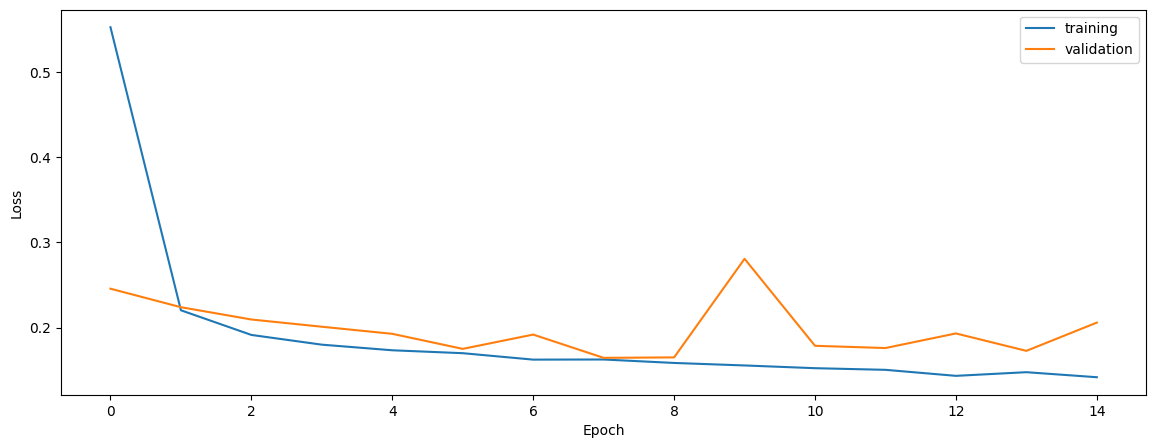

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

print('train')
print(getAccuracy(train[1],predictInBatches(model,train[0],architecture['batch_size'])))
print(getAccuracy(val[1],predictInBatches(model,val[0],architecture['batch_size'])))
print(getAccuracy(test[1],predictInBatches(model,test[0],architecture['batch_size'])))

train


0.9397204901056313


0.938295155365673


0.9296180638962287


In [8]:
props2 = props.copy()
props2['balance_data'] = False
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

print('native')
print(getAccuracy(train2[1],predictInBatches(model,train2[0],architecture['batch_size'])))
print(getAccuracy(val2[1],predictInBatches(model,val2[0],architecture['batch_size'])))
print(getAccuracy(test2[1],predictInBatches(model,test2[0],architecture['batch_size'])))

native


0.9479140321218494


0.9365456683388179


0.9248530160640711


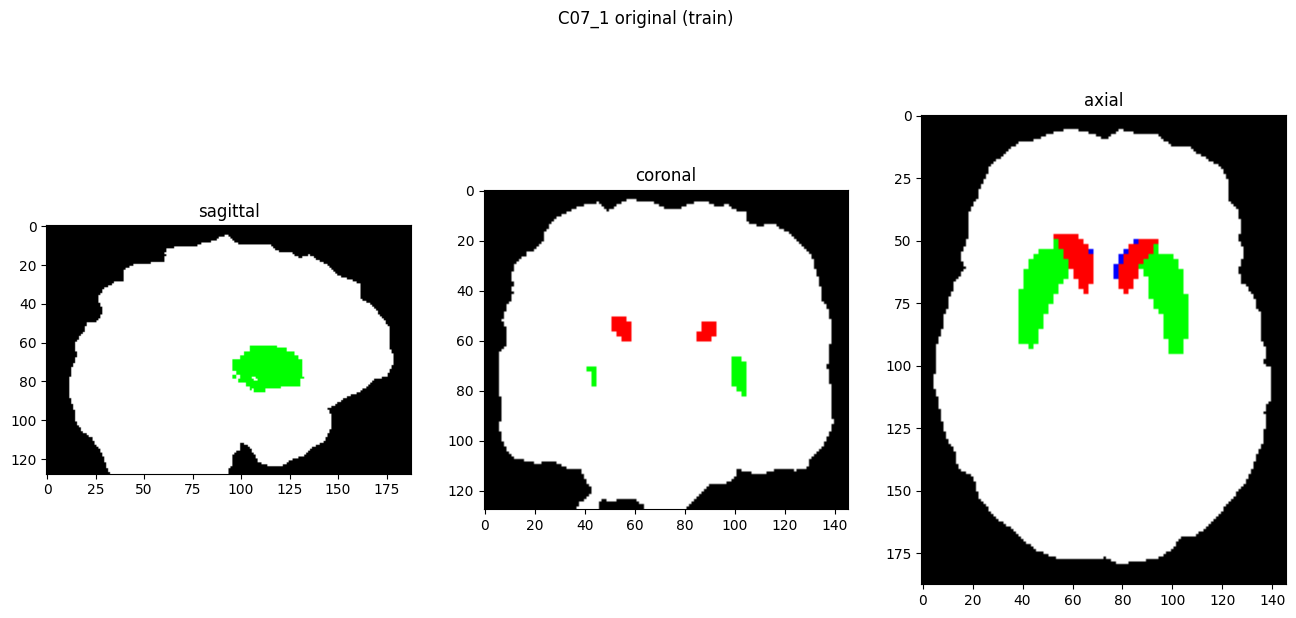

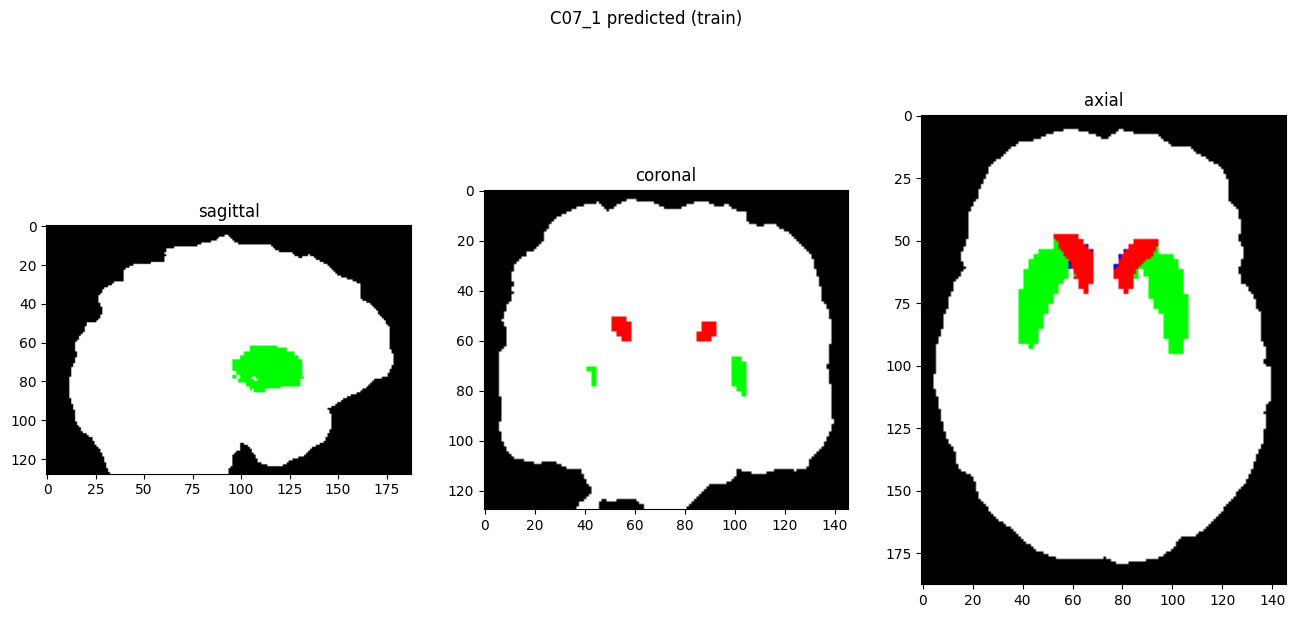

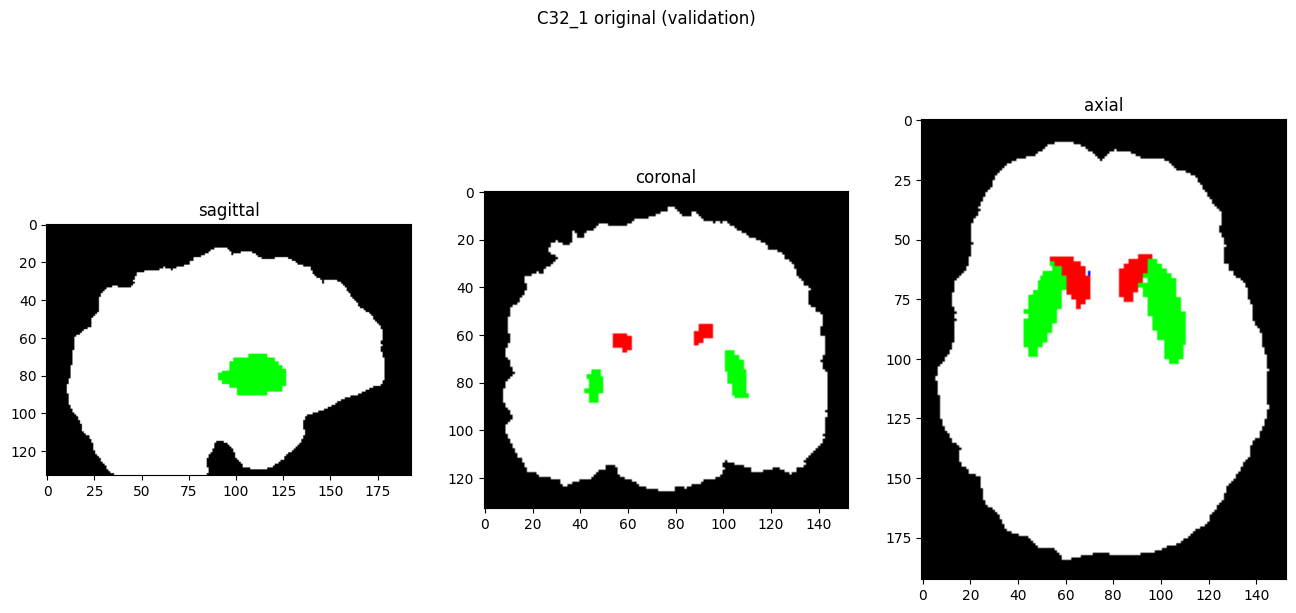

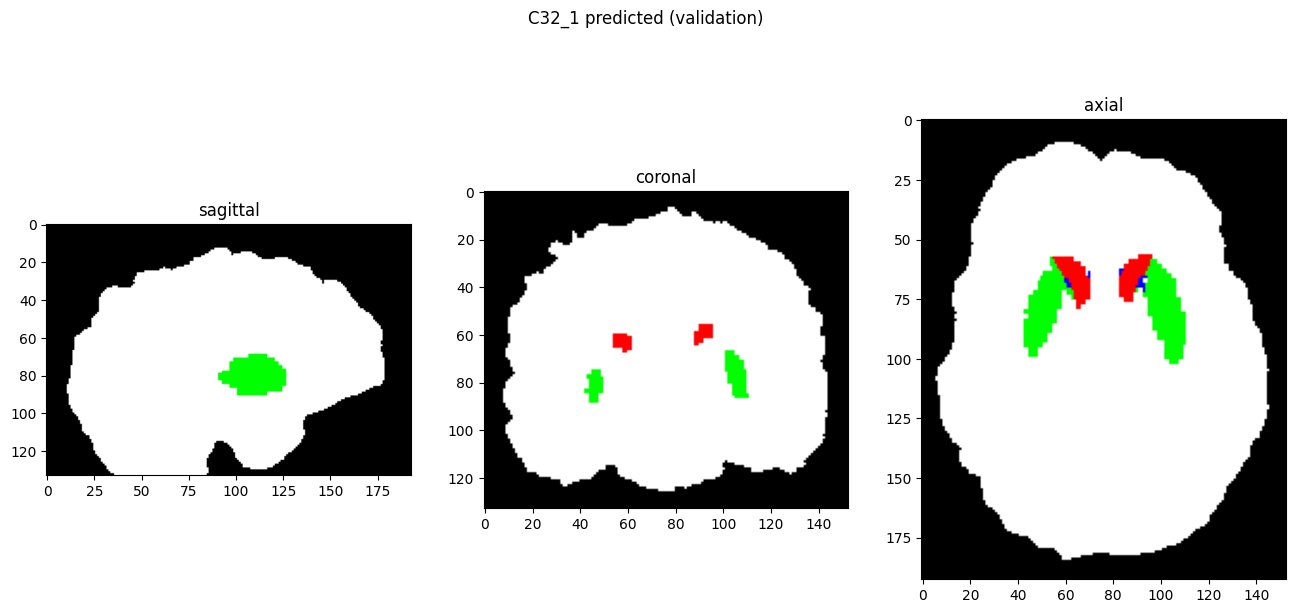

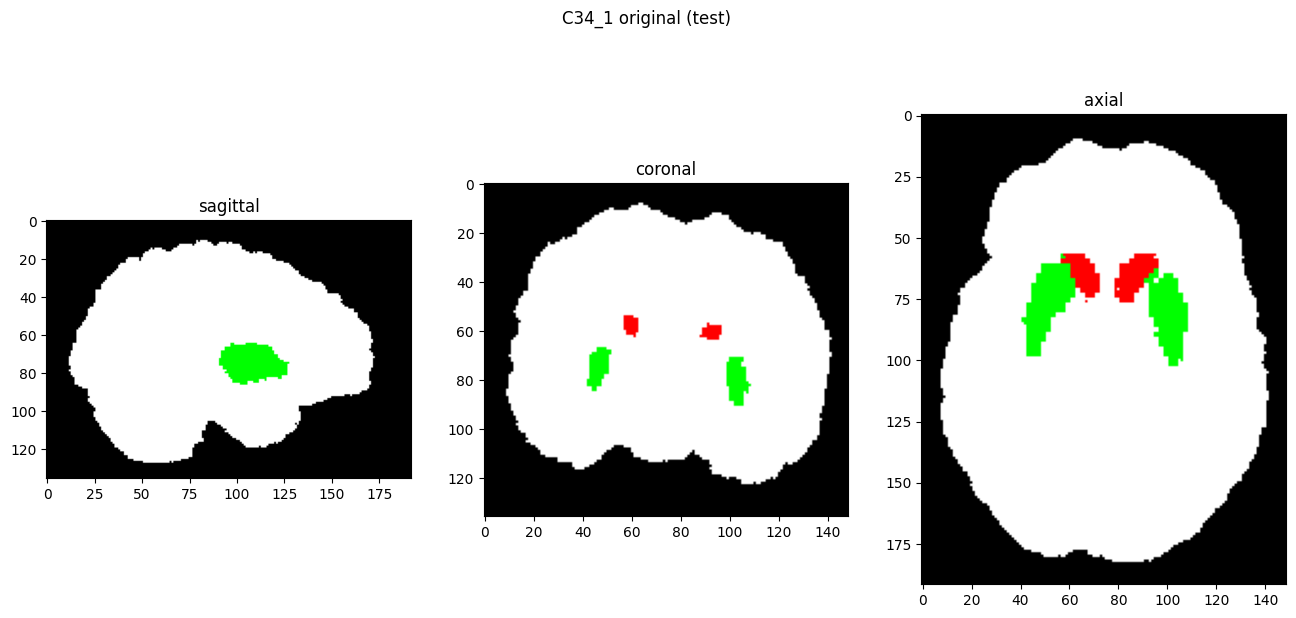

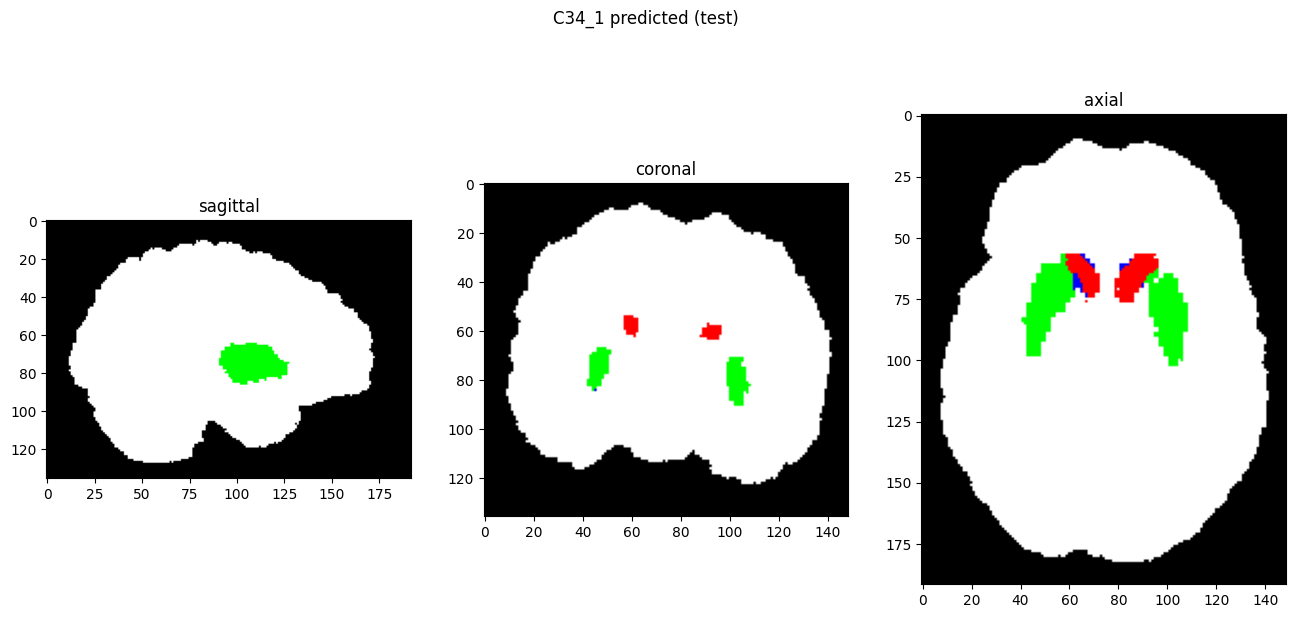

In [9]:
showResults(model, gen, threshold=0)